## Wisdom Holman Algorithm 
 - code computes Wisdom Holman algorithm with switching functions
 - computes symplecticity using autodiff
 - also computes energy error
 - includes functions for converting coordinate systems and arrays, plotting orbits, etc

In [15]:
import autograd.numpy as np  
from autograd import jacobian
import matplotlib.pyplot as plt
import sys
from datetime import datetime
from mpl_toolkits import mplot3d
%matplotlib inline 

Different initial conditions can be computed either using the function or choosing planets from the IC given for the outer gas giants:

In [2]:
def gettestdata(a,m1,m2,G):
    """given parameter a between 0 and 1 (distance between orbits=1-a)
    returns initial conditions for circular orbits in format [[qsun,psun],[q1,p1],[q2,p2]]
    test planets start on opposite sides"""
    r1=(1.+a)
    r2=2.
    w1=[[r1,0.,0.],[0.,m1*np.sqrt(G/r1),0.]]
    w2=[[-r2,0.,0.],[0.,m2*np.sqrt(G/r2),0.]]
    return np.array([[[0.,0.,0.],[0.,0.,0.,]],w1,w2])

G = 0.00029591220828559104
state = gettestdata(0,1e-3,1e-3,G)
mass = [1,1e-3,1e-3]

# other test data
sun = np.array([0,0,0,0,0,0])
jupiter = np.array([-3.5023653,-3.8169847,-1.5507963,
                    0.00565429,-0.00412490,-0.00190589])
saturn = np.array([9.0755314,-3.0458353,-1.6483708,
                   0.00168318,0.00483525,0.00192462])
uranus = np.array([8.3101420,-16.2901086,-7.2521278,
                   0.00354178,0.00137102,0.00055029])
neptune = np.array([11.4707666,-25.7294829,-10.8169456,
                    0.00288930,0.00114527,0.00039677])
pluto = np.array([-15.5387357,-25.2225594,-3.1902382,
                  0.00276725,-0.00170702,-0.00136504])


masses_js = np.array((1,0.000954786104043,0.000285583733151))
p_q_js = np.array([[sun[0:3],masses_js[0]*sun[3:6]],
                   [jupiter[0:3],masses_js[1]*jupiter[3:6]],
                   [saturn[0:3],masses_js[2]*saturn[3:6]]])

Allows for conversion of coordinates from Cartesian to democratic heliocentric:

In [3]:
def cart_to_helio(old_vars,m):
    """
    Converts Cartesian coordinates to democratic heliocentric coordinates.
    old_vars: numpy array of variables in Cartesian coordinates, num_planets + 1 
               by 2 by 3 array
    m: masses of planets (same order as in old_vars number of planets + 1 by array)
    returns: new array of variables, same shape and same order
    """
    # preliminairies
    n = len(old_vars)  # number of planets plus sun
    m_tot = np.sum(m)  # total mass of all planets and sun
    new_vars = np.zeros(np.shape(old_vars))  # initalize array of same shape
    
    #the P0s and Q0s
    for i in range(n):
        new_vars[0,0] += (m[i] / m_tot) * old_vars[i,0]
        new_vars[0,1] += old_vars[i,1]
        
    ### other Ps and Qs
    for i in range(1,n):
        new_vars[i,0] = old_vars[i,0] - old_vars[0,0]
        new_vars[i,1] = old_vars[i,1] - (m[i] / m_tot) * new_vars[0,1]
        
    return new_vars


def helio_to_cart(old_vars,m):
    """
    Converts democratic heliocentric coordinates to Cartesian coordinates.
    old_vars: numpy array of variables in Cartesian coordinates, num_planets + 1 
               by 2 by 3 array
    m: masses of planets (same order as in old_vars number of planets + 1 by array)
    returns: new array of variables, same shape and same order
    """
    # preliminairies
    n = len(old_vars)  # number of planets plus sun
    m_tot = np.sum(m)  # total mass of all planets and sun
    new_vars = np.zeros(np.shape(old_vars))  # initalize array of same shape
    
    ### the P0s and Q0s
    # initialize
    new_vars[0,0] = old_vars[0,0]
    new_vars[0,1] = (m[0] / m_tot) * old_vars[0,1]
    # iterate
    for i in range(1,n):
        new_vars[0,0] -= (m[i] / m_tot) * old_vars[i,0]
        new_vars[0,1] -= old_vars[i,1]
        
    ### other Ps and Qs
    for i in range(1,n):
        new_vars[i,0] = new_vars[0,0] + old_vars[i,0]
        new_vars[i,1] = (m[i] / m_tot) * old_vars[0,1] + old_vars[i,1]
        
    return new_vars

def flatten(coords):
    " flattens num_objects by 2 by 3 array to 1d array"
    n = len(coords)
    l = []
    for i in range(n):
        l += [coords[i,0,0],coords[i,0,1],coords[i,0,2]]
    for i in range(n):
        l += [coords[i,1,0],coords[i,1,1],coords[i,1,2]]
    return np.array(l)

Here are some switching functions to try:

In [4]:
def K1(x):
    return 1

def K0(x):
    return 0  

k = 5.
def Kt(x):
    y = 1 - x
    return 1./2.*(1. + np.tanh(k*y))


def Kdt(x):
    y = 1 - x
    #return 0. # Setting the derivative to zero somehow makes the result better. 
    return -k/2./(np.cosh(k*y))**2

def Heavi(x):
    """ 
    Returns Heaviside function with switch at x = 0.5
    x : flt
    """
    if x < 0.5:
        return 0
    else:
        return 1
    
def Heavi_deriv(x):
    """ Returns derivative of the Heaviside function with switch at x = 0.5
    x : flt
    """
    if x == 0.5:
        return np.inf
    else:
        return 0

This function computes the energy (Hamiltonian) of an array of position and momenta:

In [5]:
def energy(qp,m,G):
    """
    Returns Hamiltonian given position and velocity in heliocentric coordinates
    qp: 1D array x1,y1,z1,x2,...,zn,px1,...,pzn (np array size (n*2*3,))
    m: num planets + 1 array of masses (np array size (n,))
    G: gravitational constant (flt)
    Returns: energy (flt)
    """
    n = int(len(qp)/6)
    q, p = qp[0:3*n], qp[3*n:]
    V = 0  # potential energy
    T = 0  # kinetic energy
    
    for i in range(1,n):
        V -= G * m[i] * m[0] / (np.dot(q[i*n:i*n+3],q[i*n:i*n+3])**0.5)
        for j in range(1,i):
            diff = q[i*n:i*n+3]-q[j*n:j*n+3]
            V -= G * m[i] * m[j] / np.dot(diff,diff)**0.5
    T += np.dot(p[0:3],p[0:3]) / (2*np.sum(m))
    P_tot = 0
    for i in range(1,n):
        T += np.dot(p[i*n:i*n+3],p[i*n:i*n+3])/(2*m[i])
        P_tot += p[i*n:i*n+3]
    T += np.dot(P_tot,P_tot) / (2 * m[0])
    
    return V + T

These functions compute dR for the different steps of Wisdom Holman. I have them separate because H_B1, H_B2, H_A take different arguments but it would be nice to have one function that can be used in all three cases.

In [6]:
def dR_HB1(f,qp,m,h,G):
    """ 
    Calculates the symplecticity of HB1
    f: function to check symplecticity of (function)
    qp: initial position and momenta (1D np array of x1,y1,...,pyn,pzn)
    m: array of masses, same order as planets (1d numpy array of size n)
    G: gravitational constant (flt)
    Returns: Sum of elements in remainder matrix (dR), flt
    """
    n = int(len(qp)/2)
    getJ = jacobian(f,0)
    J = getJ(qp,m,h,G)
    one = np.identity(n)
    zero = np.zeros((n,n))
    I = np.bmat([[zero,one],[-one,zero]])
    return np.sum(abs(I-J.T*I*J))

def dR_HB2(f,qp,m,h,G,K,Kd):
    """ 
    Calculates the symplecticity of HB2
    f: function to check symplecticity of (function)
    qp: initial position and momenta (1D np array of x1,y1,...,pyn,pzn)
    m: array of masses, same order as planets (1d numpy array of size n)
    G: gravitational constant (flt)
    K, Kd: switching function and its derivative (functions)
    Returns: Sum of elements in remainder matrix (dR), flt
    """
    n = int(len(qp)/2)
    getJ = jacobian(f,0)
    J = getJ(qp,m,h,G,K,Kd)
    one = np.identity(n)
    zero = np.zeros((n,n))
    I = np.bmat([[zero,one],[-one,zero]])
    return np.sum(abs(I-J.T*I*J))

def dR_HA(f,qp,m,h,G,K,Kd,dt_steps):
    """ 
    Calculates the symplecticity of HB2
    f: function to check symplecticity of (function)
    qp: initial position and momenta (1D np array of x1,y1,...,pyn,pzn)
    m: array of masses, same order as planets (1d numpy array of size n)
    G: gravitational constant (flt)
    K, Kd: switching function and its derivative (functions)
    dt_steps: number of steps taken by Runge Kutta (int)
    Returns: Sum of elements in remainder matrix (dR), flt
    """
    n = int(len(qp)/2)
    getJ = jacobian(f,0)
    J = getJ(qp,m,h,G,K,Kd,dt_steps)
    one = np.identity(n)
    zero = np.zeros((n,n))
    I = np.bmat([[zero,one],[-one,zero]])
    return np.sum(abs(I-J.T*I*J))

Now the code for the Wisdom Holman algorithm

In [7]:
def H_B1(qp,m,h,G):
    """
    Computes H_B1 step of Wisdom Holman map
    qp: 1D array x1,y1,z1,x2,...,zn,px1,...,pzn (np array size (n*2*3,))
    m: num planets + 1 array of masses (np array size (n,))
    G: gravitational constant (flt)
    h: step size (flt)
    Returns: np array size (n*2*3,), updated positions and momenta
    """
    n = int(len(qp)/6)  # number of objects
    q,p = qp[0:3*n],qp[3*n:]  # split up p and q
    
    # compute total momentum
    ptot = np.zeros((3,))
    for i in range(1,n):
        ptot = ptot + p[i*3:i*3+3]
        
    newq = [q[0],q[1],q[2]]  # sun's position unchanged
    # update other positions 
    for i in range(1,n):
        update = q[i*3:i*3+3] + ptot * h / m[0]
        newq += [update[0]] + [update[1]] + [update[2]]
    
    newq = np.array(newq)
    return np.array([newq,p]).flatten()


def H_B2(qp,m,h,G,K,Kd):
    """
    Computes H_B2 step of Wisdom Holman map
    qp: 1D array x1,y1,z1,x2,...,zn,px1,...,pzn (np array size (n*2*3,))
    m: num planets + 1 array of masses (np array size (n,))
    G: gravitational constant (flt)
    h: step size (flt)
    K, Kd: switching function and its derivative (functions)
    Returns: np array size (n*2*3,), updated positions and momenta
    """
    n = int(len(qp)/6)  # number of objects
    q, p = qp[0:3*n], qp[3*n:]  # separate p and q
    
    newp = []  # initalize list of new momenta
    
    for i in range(0,n):
        xsum, ysum, zsum = 0, 0, 0  # initalize sums for positions
        for j in range(1,n):
            if i != j and i>0:
                rel_pos = q[i*3:i*3+3] - q[j*3:j*3+3]
                rel_pos_norm = np.dot(rel_pos,rel_pos)**0.5
                f_1 = (G * m[i] * m[j]) * (rel_pos) * K(rel_pos) \
                        / (rel_pos_norm ** 3)
                f_2 = (G * m[i] * m[j]) * (rel_pos) * Kd(rel_pos) / ((rel_pos_norm)**2)
                f = f_1 + f_2
                xsum += f[0]
                ysum += f[1]
                zsum += f[2]
        newp += [xsum] + [ysum] + [zsum]  
    # update momenta        
    newp = p - h * np.array(newp)
    return np.array([q,newp]).flatten()

    
def HA_function(qp,m,G,K,Kd):
    """
    Computes H_A step of Wisdom Holman map
    qp: 1D array x1,y1,z1,x2,...,zn,px1,...,pzn (np array size (n*2*3,))
    m: num planets + 1 array of masses (np array size (n,))
    G: gravitational constant (flt)
    h: step size (flt)
    K, Kd: switching function and its derivative (functions)
    Returns: np array size (n*2*3,), updated positions and momenta
    """
    n = int(len(qp)/6)  # number of objects
    q, p = qp[0:3*n], qp[3*n:]  # separate p and q
    
    newq = [0,0,0]  # initialize new positions
    # update position
    for i in range(1,n):
        newq += [p[i*3]/m[i]] + [p[i*3+1]/m[i]] + [p[i*3+2]/m[i]]
    
    newp = []  # initalize new momenta
    for i in range(0,n):
        if i > 0 :
            P = - G * m[i] * m[0] * q[i*3:i*3+3] / np.dot(q[i*3:i*3+3],q[i*3:i*3+3])**1.5
        else: P = [0,0,0]
        xsum, ysum, zsum = P[0], P[1], P[2]
        for j in range(1,n):
            if i != j and i>0:
                rel_pos = q[i*3:i*3+3] - q[j*3:j*3+3]
                rel_pos_norm = np.dot(rel_pos,rel_pos)**0.5
                f_1 = (G * m[i] * m[j]) * (rel_pos) * (1-K(rel_pos)) \
                        / (rel_pos_norm ** 3)
                f_2 = - (G * m[i] * m[j]) * (rel_pos) * Kd(rel_pos) / ((rel_pos_norm)**2)
                f = f_1 + f_2
                xsum += f[0]
                ysum += f[1]
                zsum += f[2]
        newp = newp + [xsum] + [ysum] + [zsum] 
        
    # new arrays for p and q (not updating with h because we use RK)
    newq = np.array(newq)
    newp = np.array(newp)
    return np.array([newq,newp]).flatten()


def H_A(qp,m,G,h,K,Kd,dt_steps):
    """
    Computes H_A step using Runge Kutta
    qp: 1D array x1,y1,z1,x2,...,zn,px1,...,pzn (np array size (n*2*3,))
    m: num planets + 1 array of masses (np array size (n,))
    G: gravitational constant (flt)
    h: step size (flt)
    K, Kd: switching function and its derivative (functions)
    dt_steps: number of Runge Kutta steps per global time step (int)
    Returns: np array size (n*2*3,), updated positions and momenta
    """
    dt = h / dt_steps
    for i in range(dt_steps):
        k1 = dt * HA_function(qp,m,G,K,Kd)
        k2 = dt * HA_function(qp+0.5*k1,m,G,K,Kd)
        k3 = dt * HA_function(qp+0.5*k2,m,G,K,Kd)
        k4 = dt * HA_function(qp+k3,m,G,K,Kd)
        qp = qp + (k1 + 2 * k2 + 2 * k3 + k4) / 6.
    return qp



def WH_switch(qp,G,m,h,K,Kd,dt_steps):
    """
    Computes one step of the Wisdom Holman map and the symplecticity of each part
    qp: 1D array x1,y1,z1,x2,...,zn,px1,...,pzn (np array size (n*2*3,))
    m: num planets + 1 array of masses (np array size (n,))
    G: gravitational constant (flt)
    h: step size (flt)
    K, Kd: switching function and its derivative (functions)
    dt_steps: number of Runge Kutta steps per global time step (int)
    Returns: tuple
            Zeroeth entry is results of WH
            First entry is symplecticity of H_B1 step
            Second entry is symplecticity of H_B2 step
            Third entry is symplecticity of H_A step
    """
    res = qp.copy()
    # H_B1
    res = H_B1(res,m,h/2,G)  
    sympB1 = dR_HB1(H_B1,res,m,h/2,G)
    # H_B2
    res = H_B2(res,m,h/2,G,K,Kd)
    sympB2 = dR_HB2(H_B2,res,m,h/2,G,K,Kd)
    # H_A
    res = H_A(res,m,h,G,K,Kd,dt_steps)
    sympA = dR_HA(H_A,res,m,h/2,G,K,Kd,dt_steps)
    # H_B1
    res = H_B2(res,m,h/2,G,K,Kd)
    sympB2 += dR_HB2(H_B2,res,m,h/2,G,K,Kd)
    # H_B2
    res = H_B1(res,m,h/2,G)
    sympB1 += dR_HB1(H_B1,res,m,h/2,G)
    
    return res, sympB1, sympB2, sympA


def WH_map(IC,m,h,G,time,K,Kd,dt_steps):
    """
    Computes Wisdom Holman algorithm
    IC: 1D array of initial conditions x1,y1,z1,x2,...,zn,px1,...,pzn (np array size (n*2*3,))
    m: num planets + 1 array of masses (np array size (n,))
    h: step size (flt)
    time: number of years to run algorithm for (flt)
    G: gravitational constant (flt)
    K, Kd: switching function and its derivative (functions)
    dt_steps: number of Runge Kutta steps per global time step (int)
    Returns: tuple
            Zeroeth entry is results array at each step (np array shape num_steps by n*6)
            First entry is energy error at each step
            Second entry is dR at each step
    """ 
    # initialize results array
    num_steps = int((365.25 / h) * time)
    res = np.zeros((num_steps,) + np.shape(IC))
    E = np.zeros(num_steps)
    dRB1 = np.zeros(num_steps)
    dRB2 = np.zeros(num_steps)
    dRA = np.zeros(num_steps)
    dR = np.zeros(num_steps)
    
    # initialize arrays
    res[0] = IC
    E[0] = energy(IC,m,G)
    dRB1[0] = dR_HB1(H_B1,IC,m,h/2,G)
    dRB2[0] = dR_HB2(H_B2,IC,m,h/2,G,K,Kd)
    dRA[0] = dR_HA(H_A,IC,m,h/2,G,K,Kd,dt_steps)
    dR[0] = dRB1[0] + dRB2[0] + dRA[0] 

    # compute each step
    for step in range(1,num_steps):
        res[step],dRB1[step],dRB2[step],dRA[step] = WH_switch(res[step-1].copy(),G,m,h,K,Kd,dt_steps)
        E[step] = abs((energy(res[step],m,G) - E[0]) / E[0])
        dR[step]= dRB1[step] + dRB2[step] + dRA[step] 
        
        # prints percentage of algorithm computed 
        if step == num_steps - 1:
            a = '100.0%'
        else:
            a = '%.1f' % (step * 100 / num_steps) + '%'
        sys.stdout.write('\r'+a)
        sys.stdout.flush()
        
    return res, E, dR

Let's test the algorithm! Here I set the parameters:

In [8]:
IC = cart_to_helio(state,mass)
IC_js = cart_to_helio(p_q_js,masses_js)


IC= flatten(IC)
IC_js = flatten(IC_js)


time = 10  # in years
h = 6
dt_steps = 60
G = 0.00029591220828559104

I first test the algorithm with no switching. To do that, run WH_map with K1 as the switching function and K0 as its derivative.

In [9]:
start = datetime.now()
test1=WH_map(IC,mass,h,G,time,K1,K0,dt_steps)
print('Time for WH map, 2 planets, 10 years:',str(datetime.now() - start))

100.0%Time for WH map, 2 planets, 10 years: 2:09:30.165707


Plot energy error at each time step

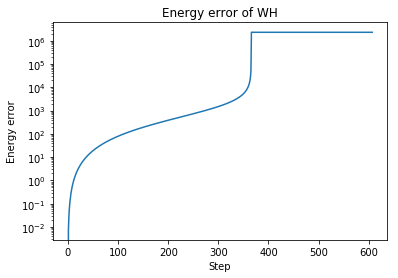

In [10]:
plt.plot(test1[1])
plt.title('Energy error of WH')
plt.xlabel('Step')
plt.ylabel('Energy error')
plt.yscale('log') 
plt.show()

Plot the symplecticity at each time step

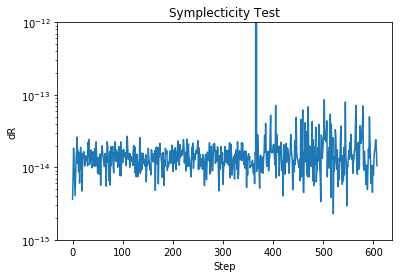

In [11]:
plt.plot(test1[2])
plt.title('Symplecticity Test')
plt.xlabel('Step')
plt.ylabel('dR')
plt.yscale('log') 
plt.ylim(1e-15,1e-12)
plt.show()

Convert the results of the Wisdom Holman mapping to Cartesian coordinates to plot the orbits

In [12]:
def rebuild(qp):
    """ Rebuilds flat qp array into shape (n,2,3)"""
    n = int(len(qp)/6)
    res = np.zeros((n,2,3))
    for i in range(n):
        res[i,0] = qp[i:i+3]     
        res[i,1] = qp[i+n*3:i+3+n*3]
    return res

def Rebuild(results,m):
    """ Takes WH map results, rebuild to shape (n,2,3), and converts to 
        Cartesian coordinates
    results: results of WH mapping, np array shape (num_steps,n*2*3)
    m: masses, np array shape (n,)
    Returns: results in Cartesian coordinates, np array shape (n,2,3)
    """
    n = int(len(results[0])/6)
    num_steps = len(results)
    res = np.zeros((num_steps,n,2,3))
    for step in range(num_steps):
        res[step] = rebuild(results[step])
        res[step] = helio_to_cart(res[step],m)
    return res
    
test1_cartesian = Rebuild(test1[0],mass)

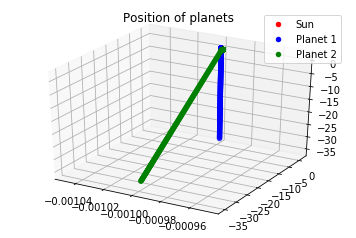

In [16]:
def plot_orbits(cart_results):
    """
    For two planets and sun
    Plots the results of the WH algorithm in x,y,z plane
    cart_results: result of WH algorithm in Cartesian coordinates,
                    np array size (num_steps,n,2,3)
    """
    ax = plt.axes(projection='3d')
    ax.scatter3D(cart_results[:,0,0,0],cart_results[:,0,0,1],cart_results[:,0,0,2],c='red',label='Sun')
    ax.scatter3D(cart_results[:,1,0,0],cart_results[:,1,0,1],cart_results[:,1,0,2],c='blue',label='Planet 1')
    ax.scatter3D(cart_results[:,2,0,0],cart_results[:,2,0,1],cart_results[:,2,0,2],c='green',label='Planet 2')
    ax.legend()
    plt.title('Position of planets')
    plt.show()
    return None

 
plot_orbits(test1_cartesian)

Plot the distance between the two planets over time. This will help us decide on the threshhold for the switching functions.

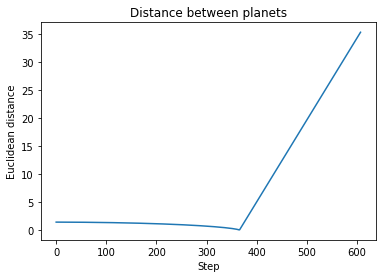

In [17]:
def plot_planet_vs(cart_results):
    """
    For two planets and sun
    Plots distance between the two planets (useful for switching function)
    cart_results: result of WH algorithm in Cartesian coordinates,
                    np array size (num_steps,n,2,3)
    """
    num_steps = len(cart_results)
    
    # compute distance
    res = np.zeros((num_steps,))
    for i in range(num_steps):
        dist = cart_results[i,1,0] - cart_results[i,2,0]
        res[i] = np.linalg.norm(dist)      
        
    # plot
    plt.plot(res)
    plt.title('Distance between planets')
    plt.xlabel('Step')
    plt.ylabel('Euclidean distance')
    plt.show()
    
    return None

plot_planet_vs(test1_cartesian)